In [ ]:
import pandas as pd # pd is simply an alias 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Part I. Pre-processing a real dataset

The [Breast Cancer Wisconsin (Diagnostic) Data Set](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) contains 10 features related to breast tumors that have been diagnosed as benign or malignant. You have a description of the 10 features in the link above. In the same link you can download the data set as a CVS file.

In [ ]:
''' Data is stored in a Dataframe, a particular data type implemented in Pandas'''

from google.colab import files
uploaded = files.upload()
data = pd.read_csv('./breast-cancer-wisconsin.csv')

MessageError: ignored

Lets visualize the first 10 entries of the database with the `.head()` method

In [ ]:
data.head(10)

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4
6,1018099,1,1,1,1,2,10.0,3,1,1,2
7,1018561,2,1,2,1,2,1.0,3,1,1,2
8,1033078,2,1,1,1,2,1.0,1,1,5,2
9,1033078,4,2,1,1,2,1.0,2,1,1,2


With the `.shape()` method we can check how many datapoints we have

In [ ]:
print('There are %d data points. Each one of dimension %d' %(data.shape[0],data.shape[1]))

There are 699 data points. Each one of dimension 11


We will do the following preprocessing steps. All of them are implemented in Pandas (it is advisory for very large databases):

- Remove the 'ID' column. We won't use it anymore

- Replace missing data (Encoded in this database with a '?' by the column mode). 

- The tumor class is equal to 2 for bening tumors and to 4 for malignat tumors. We will replace this by 0 and 1 respectively

- Create a train set and a test set

- We will normalize all input variables so they all have zero mean and unit variance

### Remove ID colum

We can use the `.drop()` method. We use the input `inplace=True` to override the existing Dataframe.

In [ ]:
data.drop('ID',axis=1,inplace=True)

In [ ]:
# Lets check the result

data.head(10)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1.0,3,1,1,2
1,5,4,4,5,7,10.0,3,2,1,2
2,3,1,1,1,2,2.0,3,1,1,2
3,6,8,8,1,3,4.0,3,7,1,2
4,4,1,1,3,2,1.0,3,1,1,2
5,8,10,10,8,7,10.0,9,7,1,4
6,1,1,1,1,2,10.0,3,1,1,2
7,2,1,2,1,2,1.0,3,1,1,2
8,2,1,1,1,2,1.0,1,1,5,2
9,4,2,1,1,2,1.0,2,1,1,2


### Replace missing data by column mode

Pandas considers values like `NaN` and `None` to represent missing data. The `pandas.isnull` function can be used to tell whether or not a value is missing. 

Let's use `apply()` across all of the columns in our DataFrame to figure out which values are missing.

In [ ]:
empty = data.apply(lambda col: pd.isnull(col))

In [ ]:
empty.sum()

Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

Observe that one of the columns has 16 missing entries. Lets replace them with the mode of the column.

In [ ]:
data['Bare Nuclei'].mode()[0]

1.0

In [ ]:
data['Bare Nuclei'].fillna(data['Bare Nuclei'].mode()[0], inplace=True)

In [ ]:
empty = data.apply(lambda col: pd.isnull(col))
empty.sum()

Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

### Create a binary class label

To do so, we will create a simple function to convert the label and store the result in a new colum of the dataframe

In [ ]:
def convert_to_binary(l):
    return (l-2.0)/2

In [ ]:
# We create the new column

data['Binary Class'] = data[['Class']].apply(lambda l: convert_to_binary(l))

data.drop('Class',axis=1,inplace=True)

Lets take a look to the histogram of the binary class label

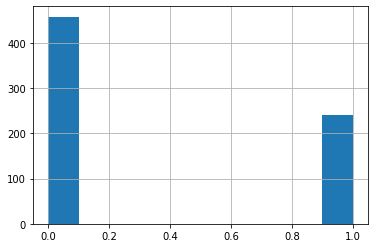

In [ ]:
data['Binary Class'].hist()

### Create a train and test sets

We will simply split the dataset at random. 80% of the data will go to the training set, the rest to the test set. We will use [Numpy's random permutation function](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.permutation.html) and the `.iloc()` method. 

In [ ]:
frac_train = 0.7

data_train = int(data.shape[0]*frac_train) # Training points

np.random.seed(seed=10) #To fix the random seed. So we all get the same partition

mask = np.random.permutation(data.shape[0]) # Random order of data indexes

train_data = data.iloc[list(mask[:data_train])].copy()

test_data = data.iloc[list(mask[data_train:])].copy()


Note that we store the train and test data in separate Dataframes, so we can normalize them without modifying the oringinal data (We could add more columns to the original Dataframe, but this would be later on annoying to index).

### Normalize input variables 

In general, it is not recommended that input variables (or features) are defined in different ranges. I.e., $x_1$ for instance takes values in the $[-1,1]$ set and $x_2$ takes values in the $[-10^6,10^6]$ range. 

To improve both the numerical robustness of our estimators and **enhance interpretability**, we will apply a linear normalization preprocessing stage to use as input to the linear regression features with (sample) mean 0 and (sample) variance equal to 1. 

Given the unnormalized feature matrix $\mathbf{X}_{N\times D}$, we compute the sample mean per feature column, $\mu_j$, and the sample variance per  feature column, $\sigma^2_j$ for $j=1,\ldots,D$. Then, each row of the normalized feature matrix $\overline{\mathbf{X}}_{N\times D}$ is obtained as follows:

$$\overline{\mathbf{x}}^{(i)}= \left[\frac{x_1^{(i)}-\mu_1}{\sqrt{\sigma^2_1}}, ~~ \frac{x_1^{(i)}-\mu_2}{\sqrt{\sigma^2_2}}, \ldots, \frac{x_1^{(D)}-\mu_1}{\sqrt{\sigma^2_D}}\right]$$

**Note this does not affect to the logistic regression solution**, we are simply re-scaling the parameter vector $\boldsymbol{w}$. Using this scaling, we can now effectively compare the effect that each variable has in the logistic regression solution: **the larger $|w_j|$ is, the more effect the $j$-th feature has in the estimation of the class**.

One important aspect is that the test set is normalized **using the train set statistics (mean and variance)**

In [ ]:
means = train_data.mean()
stds = train_data.std()

In [ ]:
for column_name in train_data.keys()[:-1]:
    train_data[column_name] = (train_data[column_name]-means[column_name])/(stds[column_name])
    test_data[column_name] = (test_data[column_name]-means[column_name])/(stds[column_name])

Lets take a look to the resulting dataframe

In [ ]:
train_data.head(10)

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Binary Class
285,1.312402,2.290172,2.279400,2.403579,2.253071,1.762256,2.637255,1.314188,0.839391,1.0
607,-1.215652,-0.697983,-0.748562,-0.651924,-0.545621,-0.699086,-1.020658,-0.606045,-0.343497,0.0
587,0.228950,-0.697983,-0.748562,-0.651924,-0.545621,-0.699086,-0.614223,-0.286006,-0.343497,0.0
458,0.228950,-0.697983,-0.412122,-0.651924,-0.545621,-0.699086,-1.020658,-0.606045,-0.343497,0.0
431,0.228950,-0.697983,-0.748562,0.027077,0.387276,-0.699086,-0.207789,-0.286006,-0.343497,0.0
52,2.034704,-0.033949,0.933639,-0.312424,-0.079172,0.394844,0.198646,2.274304,0.247947,1.0
560,0.228950,-0.697983,-0.748562,-0.651924,-0.545621,-0.699086,-0.207789,-0.606045,-0.343497,0.0
445,-0.854502,-0.697983,-0.748562,-0.651924,-0.545621,-0.699086,-1.020658,-0.606045,-0.343497,0.0
292,1.312402,1.626138,1.606520,-0.651924,-0.545621,-0.699086,1.011516,2.274304,-0.343497,1.0
579,-1.215652,-0.697983,-0.748562,-0.651924,-0.545621,-0.699086,-0.207789,-0.606045,-0.343497,0.0


## Part II. Tensors in Pytorch


Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

PyTorch in a lot of ways behaves like  Numpy arrays. PyTorch takes these tensors and makes it simple to move them to GPUs for the faster processing needed when training neural networks. It also provides a module that automatically calculates gradients and another module specifically for building neural networks. 

It turns out neural network computations are just a bunch of linear algebra operations on *tensors*, a generalization of matrices. A vector is a 1-dimensional tensor, a matrix is a 2-dimensional tensor, an array with three indices is a 3-dimensional tensor (RGB color images for example). The fundamental data structure for neural networks are tensors and PyTorch (as well as pretty much every other deep learning framework) is built around tensors.


### Creating and manipulating tensors

In [ ]:
# First, import PyTorch
import torch

Lets create a function to manipulate torch tensors ...

In [ ]:
def activation(x):
    """ Sigmoid activation function 
    
        Arguments
        ---------
        x: torch.Tensor
    """
    return 1/(1+torch.exp(-x))

In [ ]:
### Generate some data
torch.manual_seed(7) # Set the random seed so things are predictable

# Features are 5 random normal variables
features = torch.randn((1, 5))
# True weights for our data, random normal variables again
weights = torch.randn_like(features)
# and a true bias term
bias = torch.randn((1, 1))

Above we generated data we can use to get the output of our simple network. This is all just random for now, going forward we'll start using normal data. Going through each relevant line:

`features = torch.randn((1, 5))` creates a tensor with shape `(1, 5)`, one row and five columns, that contains values randomly distributed according to the normal distribution with a mean of zero and standard deviation of one. 

`weights = torch.randn_like(features)` creates another tensor with the same shape as `features`, again containing values from a normal distribution.

Finally, `bias = torch.randn((1, 1))` creates a single value from a normal distribution.

PyTorch tensors can be added, multiplied, subtracted, etc, just like Numpy arrays. In general, you'll use PyTorch tensors pretty much the same way you'd use.

> **Exercise**: Using the `activation()` function, calculate the output a binary logistic regressor with input features `features`, weights `weights`, and bias `bias`. Similar to Numpy, PyTorch has a [`torch.sum()`](https://pytorch.org/docs/stable/torch.html#torch.sum) function, as well as a `.sum()` method on tensors, for taking sums. Use the function `activation` defined above as the activation function.

In [ ]:
### YOUR CODE HERE

y = activation(torch.mm(features, torch.t(weights) + bias))


You can do the multiplication and sum in the same operation using a matrix multiplication. In general, you'll want to use matrix multiplications since they are more efficient and accelerated using modern libraries and high-performance computing on GPUs.  For this we can use [`torch.mm()`](https://pytorch.org/docs/stable/torch.html#torch.mm) or [`torch.matmul()`](https://pytorch.org/docs/stable/torch.html#torch.matmul) which is somewhat more complicated and supports broadcasting.

First, check the dimension of `features` and `weights` using the method `.shape`

In [ ]:
print(features.shape)
print(weights.shape)

torch.Size([1, 5])
torch.Size([1, 5])


> **Exercise**: See what comes if you try to directly multiply both tensors

In [ ]:
### YOUR CODE HERE
#prod= torch.mm(features, weights)

What's happening here is our tensors aren't the correct shapes to perform a matrix multiplication. There are a few options here: [`weights.reshape()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.reshape), [`weights.resize_()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.resize_), and [`weights.view()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view).

* `weights.reshape(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)` sometimes, and sometimes a clone, as in it copies the data to another part of memory.
* `weights.resize_(a, b)` returns the same tensor with a different shape. However, if the new shape results in fewer elements than the original tensor, some elements will be removed from the tensor (but not from memory). If the new shape results in more elements than the original tensor, new elements will be uninitialized in memory. Here I should note that the underscore at the end of the method denotes that this method is performed **in-place**. Here is a great forum thread to [read more about in-place operations](https://discuss.pytorch.org/t/what-is-in-place-operation/16244) in PyTorch.
* `weights.view(a, b)` will return a new tensor with the same data as `weights` with size `(a, b)`.

Any of the three methods will work for this. So, now we can reshape `weights` to have five rows and one column with something like `weights.view(5, 1)`.


> **Exercise**: Calculate the output of the logistic regressor using matrix multiplication.

In [ ]:
y = activation(torch.mm(features, weights.view(5,1)) + bias)

In [ ]:
print(y)

tensor([[0.1595]])


### Numpy to Torch and back

PyTorch has a feature for converting between Numpy arrays and Torch tensors. To create a tensor from a Numpy array, use `torch.from_numpy()`. To convert a tensor to a Numpy array, use the `.numpy()` method.

In [ ]:
a = np.random.rand(4,3)
a

array([[0.29507589, 0.18333855, 0.01973246],
       [0.74332123, 0.0382934 , 0.43367967],
       [0.83208476, 0.01345856, 0.50933539],
       [0.4795487 , 0.02965494, 0.01142853]])

In [ ]:
b = torch.from_numpy(a)
b

tensor([[0.2951, 0.1833, 0.0197],
        [0.7433, 0.0383, 0.4337],
        [0.8321, 0.0135, 0.5093],
        [0.4795, 0.0297, 0.0114]], dtype=torch.float64)

In [ ]:
b.numpy()

array([[0.29507589, 0.18333855, 0.01973246],
       [0.74332123, 0.0382934 , 0.43367967],
       [0.83208476, 0.01345856, 0.50933539],
       [0.4795487 , 0.02965494, 0.01142853]])

The memory is shared between the Numpy array and Torch tensor, so if you change the values in-place of one object, the other will change as well.

In [ ]:
# Multiply PyTorch Tensor by 2, in place (Note the _)
b.mul_(2)

tensor([[0.5902, 0.3667, 0.0395],
        [1.4866, 0.0766, 0.8674],
        [1.6642, 0.0269, 1.0187],
        [0.9591, 0.0593, 0.0229]], dtype=torch.float64)

In [ ]:
# Numpy array matches new values from Tensor
a

array([[0.59015179, 0.3666771 , 0.03946492],
       [1.48664246, 0.07658681, 0.86735934],
       [1.66416952, 0.02691712, 1.01867078],
       [0.9590974 , 0.05930988, 0.02285705]])

## Part III. Define a logistc regression and its loss function in Pytorch

#### The `nn.()` module

PyTorch provides a module `nn` that makes building neural networks much simpler. 


In [ ]:
from torch import nn

You should to get use to inspect [Pytorch official documentation](https://pytorch.org/docs/stable/index.html) to understand the structure and usability of methods and classes required to work with Pytorch and train neural networks.

With the following code I show you how to create a Logistic Regression network whose parameters will be later on optimized for our data.

In [ ]:
class LR(nn.Module):
    def __init__(self,dimx):
        super().__init__()
        
        self.weights = nn.Parameter(torch.randn(dimx,1),requires_grad = True)
        
        self.bias = nn.Parameter(torch.randn(1,1),requires_grad = True)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.sigmoid(torch.matmul(x,self.weights)+self.bias)
        return x

Let's go through this bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.weights = nn.Parameter(torch.randn(dimx,1),requires_grad = True)
self.bias = nn.Parameter(torch.randn(1,1),requires_grad = True)
```

The Parameter class defines a kind of Tensor that is to be considered a module parameter. Namely, we will optimize the values of these tensors. Note that we define a random optimization.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.


### A more compact definition of the network using pre-defined layers

The `.nn` package provides us with predefined layers and operators so that the implementation of our networks is indeed much easier (and compact). The following code performs exactly as the class `LR` defined above.

In [ ]:
class LR2(nn.Module):
    def __init__(self,dimx):
        super().__init__()
        
        self.output = nn.Linear(dimx,1)
    
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output(x)
        x = self.sigmoid(x)
        return x

When we define a logistic regressor by instantiating the class `LR2`, we can access the weights and the bias as `self.output.weight` and `self.output.bias`



#### Evaluate the logistic regressor using our data. The autograd module

Lets take the first 10 datapoints in the training set

In [ ]:
x = np.array(train_data[:10]).astype(np.float32)
y = x[:,-1]    # Last Column is the class
x = x[:,:-1]

NameError: ignored

> **Exercise:** Instantiate the class `LR` or `LR2` with the right input dimension

In [ ]:
## YOUR CODE HERE

dimx=x.shape[1]
my_classifier = LR(dimx)

To evaluate the logistic regressor output for the data in `x`, we make use of the class `forward` method. Do not forget to feed the function with a **torch tensor**.

In [ ]:
output = my_classifier.forward(torch.tensor(x)) # estos nums son probabilidades

In [ ]:
print(output)

tensor([[1.0000],
        [0.0122],
        [0.0343],
        [0.0159],
        [0.2592],
        [0.9999],
        [0.0173],
        [0.0128],
        [0.9866],
        [0.0143]], grad_fn=<SigmoidBackward>)


Above we can see the operation that created `output`, a sigmoid operation `SigmoidBackward`. The autograd module keeps track of all operations that affect Parameter tensors and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the binary cross entropy. We will use the class `nn.BCE()`. See how to use the function in the [official documentation](https://pytorch.org/docs/stable/nn.html).

In [ ]:
bce = nn.BCELoss()

In [ ]:
loss = bce(output,torch.tensor(y).view(10,1))

print(loss)

tensor(0.0422, grad_fn=<BinaryCrossEntropyBackward>)


Above we can see the operation that created `loss`, a binary cross entropy `BinaryCrossEntropyBackward`.


Now that we know how to calculate a loss, Torch provides a module, `autograd`, for automatically calculating the gradients of the loss w.r.t. the tensors. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way.
To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`. By default, all tensors created by instantiating the class `nn.Parameter` have `requires_grad = True`.

> **Exercise**: Check that both the weights and the bias of the class `LR` and `LR2` have this flag set to `True`


In [ ]:
#YOUR CODE HERE 
print(my_classifier.weights.requires_grad)
print(my_classifier.bias.requires_grad)

True
True


You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`. Turning off gradients is recommended for instance when you are just evaluating you network, i.e., when training is finished and only parameter evaluation is required.


### The `.backward()` operator


The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent.

After calling  `loss.backward()` the gradient of `loss` w.r.t. to any tensor `x` can be accessed as `x.grad`


> **Exercise**: Given the tensor $x$ (of size $10\times1$) defined below, evaluate the gradient of $y=x^T~x$ w.r.t. every component of $x$. Does it coincide with the analytical solution?

tensor([[-1.8359],
        [-0.9156],
        [-1.4489],
        [ 2.5598],
        [-1.9881],
        [ 3.6299],
        [-1.2057],
        [ 3.2296],
        [ 3.8604],
        [-0.8450]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


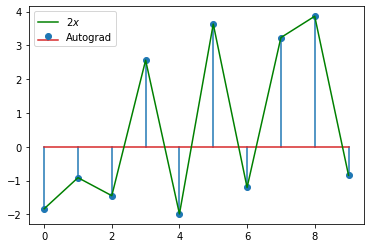

In [ ]:
x = torch.randn(10,1,requires_grad=True)

#YOUR CODE HERE

y = torch.mm(x.view(1,10),x)

print(y.grad_fn)

#YOUR CODE HERE
y.backward()

print(x.grad)  #dy/dx


# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    #YOUR CODE HERE. Plot the computed gradient vs 2*x (the analytical solution)
    plt.stem(x.grad.detach().numpy(),label='Autograd')
    plt.plot(2*x.detach().numpy(),'-g',label='$2x$')
    plt.legend()

`.detach()` method constructs a new view on a tensor which is declared not to need gradients. You can see a nice example in this [link](method constructs a new view on a tensor which is declared not to need gradients). Typically, we will use detach to export values to numpy to perform model evaluation. In Pytorch, you cannot call the `.numpy()` operators in Tensor that have `require_grad=True`.


An important aspects to implement Gradient Descent Loops is that if call again the `.backward()` operator, then **gradients are accumulated** in the variable `x.grad`. 

> **Exercise**: Check that gradients are accumulated by calling again `y.backward()`   



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


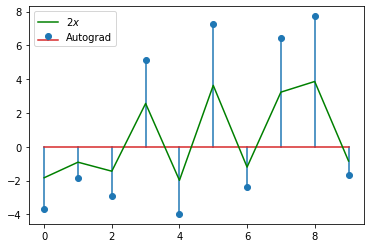

In [ ]:
y = torch.matmul(x.view(1,10),x)
#YOUR CODE HERE
print(y.grad_fn) #first we use this backward function to calculate the gradient

y.backward()

#YOUR CODE HERE. Plot the computed gradient vs 2*x (the analytical solution)
with torch.no_grad():
     #YOUR CODE HERE. Plot the computed gradient vs 2*x (the analytical solution)
    plt.stem(x.grad.detach().numpy(),label='Autograd')
    plt.plot(2*x.detach().numpy(),'-g',label='$2x$')
    plt.legend()
     
#esto era para ver que se acumulan los gradientes


In order to reset gradients, we will see that the Pytorch optimizers provide us with the appropiate method.

## Part IV. Train the logistic regressor with the complete dataset

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [ ]:
# We use all data points  

x = np.array(train_data).astype(np.float32)
# Last Column is the class
y = x[:,-1]  
x = x[:,:-1]

In [ ]:
my_classifier2 = LR2(x.shape[1])

criterion = nn.BCELoss()

output = my_classifier2.forward(torch.tensor(x))

loss = criterion(output,torch.tensor(y))

loss.backward()

print(my_classifier2.output.weight.grad.shape)  #dloss/dw shape

torch.Size([1, 9])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([489])) that is different to the input size (torch.Size([489, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


#### Defining an optimizer

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

With the following code, we can define the optimizer:


In [ ]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(my_classifier2.parameters(), lr=0.01)

To perform a SGD iteration, we simply call `optmizer.step()`


By the way, `my_classifier2.parameters()` returns a [generator object](https://realpython.com/introduction-to-python-generators/)

In [ ]:
params = my_classifier2.parameters()

print(type(params))

print(next(params))

print(next(params))

<class 'generator'>
Parameter containing:
tensor([[-0.1130,  0.0131, -0.1902, -0.1456,  0.1120,  0.1918,  0.0047, -0.1297,
          0.1825]], requires_grad=True)
Parameter containing:
tensor([-0.1827], requires_grad=True)


If we call again the method `next()` over params, Python will yield a `StopIteration` error:

In [ ]:
print(next(params))

StopIteration: ignored

#### Creating a class with both the network and a training method

Object Oriented Programming (OOP) in Python is a versatil and convenient method to implement our own software and create reusable sofware. Indeed, along this whole notebook, we have been using classes all the time.

[Here](https://www.programiz.com/python-programming/object-oriented-programming) you can find a short introduction to OOP in Python.

With the following code, we will define a class that incorporates the definition of the logistic regression network and **a method to train the parameters**. Go carefully through the code and try to understand it line by line.

In [ ]:
''' This class inherits from the LR2 class. So it has the same atributes
and methods, and some others that we will add. 
'''
class LR_extended(LR2):
    
    def __init__(self,dimx,sgd_iterations=1000,lr=0.001):
        
        super().__init__(dimx)  #To initialize LR2!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.SGD(self.parameters(), self.lr)
        
        self.sgd_iterations = sgd_iterations #SGD steps
        
        self.criterion = nn.BCELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def train(self,x,y):
        
        # SGD Loop
        
        for iter in range(int(self.sgd_iterations)):
        
            self.optim.zero_grad()  #TO RESET GRADIENTS!

            out = self.forward(x)

            loss = self.criterion(out,y)

            self.loss_during_training.append(loss.item())

            loss.backward()

            self.optim.step()
        
            if(iter % 1000 == 0): # Every 1000 iterations
                
                print("Training loss after %d iterations: %f" 
                      %(iter,self.loss_during_training[-1]))
        

Lets instantiate the class and train the logistic regressor. See how compact and easy is now (OOP is great!).

In [ ]:
my_LR = LR_extended(x.shape[1],sgd_iterations=3000,lr=0.001)

my_LR.train(torch.tensor(x),torch.tensor(y))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([489])) that is different to the input size (torch.Size([489, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Training loss after 0 iterations: 0.584372
Training loss after 1000 iterations: 0.269989
Training loss after 2000 iterations: 0.194411


Note that if you believe that training isn't finished yet, you can simply call again the `.train()` method.

In [ ]:
my_LR.train(torch.tensor(x),torch.tensor(y))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([489])) that is different to the input size (torch.Size([489, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Training loss after 0 iterations: 0.161354
Training loss after 1000 iterations: 0.143000
Training loss after 2000 iterations: 0.131391


> **Exercise**: Train from scratch the logistic regresson for 20.000 iterations and plot the evolution of the binary cross entropy loss.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([489])) that is different to the input size (torch.Size([489, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Training loss after 0 iterations: 0.642660
Training loss after 1000 iterations: 0.273910
Training loss after 2000 iterations: 0.193057
Training loss after 3000 iterations: 0.159021
Training loss after 4000 iterations: 0.140529
Training loss after 5000 iterations: 0.129000
Training loss after 6000 iterations: 0.121162
Training loss after 7000 iterations: 0.115502
Training loss after 8000 iterations: 0.111229
Training loss after 9000 iterations: 0.107893
Training loss after 10000 iterations: 0.105217
Training loss after 11000 iterations: 0.103021
Training loss after 12000 iterations: 0.101186
Training loss after 13000 iterations: 0.099629
Training loss after 14000 iterations: 0.098290
Training loss after 15000 iterations: 0.097125
Training loss after 16000 iterations: 0.096101
Training loss after 17000 iterations: 0.095193
Training loss after 18000 iterations: 0.094383
Training loss after 19000 iterations: 0.093653


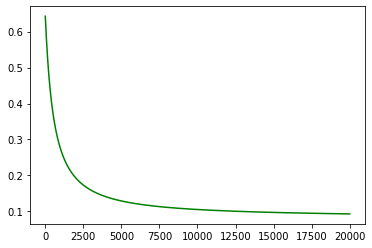

In [ ]:
# Your code here
my_LR2 = LR_extended(x.shape[1],sgd_iterations=20000,lr=0.001)
# Your code here
my_LR2.train(torch.tensor(x),torch.tensor(y))


plt.plot(my_LR2.loss_during_training,'-g',label='$Ev$')
# el error baja mucho mas rapido el SGD que el GD

> **Exercise**: Print all model parameters (e.g. weights and bias)

In [ ]:
#Your code here

print(my_LR2.output.weight)
#Your code here
print(my_LR2.output.bias)


Parameter containing:
tensor([[0.6317, 0.5438, 0.8766, 0.6921, 0.3496, 1.0436, 0.5338, 0.3506, 0.4953]],
       requires_grad=True)
Parameter containing:
tensor([-0.6319], requires_grad=True)


#### Evaluating the model in the test set

Now that we have trained our logistic regressor, it is time to compare its performance in both the training and the test sets.

> **Exercise**: Compute the logistic regressor output for both the training data and the test data.

In [ ]:
out_train = my_LR.forward(torch.tensor(x))

#Your code here
xtest = np.array(test_data).astype(np.float32)
# Last Column is the class
ytest = xtest[:,-1]   
xtest = xtest[:,:-1]

out_test = my_LR.forward(torch.tensor(xtest))

Recall that the logistic regressor output is an estimated class probability. Assuming we put the threshold at a probability of 0.5, lets count the number of errors in both sets.

In [ ]:
error_rate_train = np.sum((out_train.detach().numpy()>=0.5) 
                          == y.reshape([-1,1]))/y.shape[0]

error_rate_test = np.sum((out_test.detach().numpy()>=0.5) 
                         == ytest.reshape([-1,1]))/ytest.shape[0]

print(error_rate_train)

print(error_rate_test)

0.9652351738241309
0.9666666666666667


### Part V. Training a Logistic Regressor with mini-batch stochastic gradient descent

Finally, we are going to implement an scalable version of the gradient descent training implemented above. At every iteration, instead of evaluating the gradient using all data points, a small minibatch of data will be used.

To make sure that all training data points are evenly used to evaluate the gradient, we will use a short iterating function. Instead of predefining a certain number of SGD iterations, we define a certain number of **epochs**. After every epoch **all datapoints** have been used in the optimizer once. 


> **Exercise**: Complete the code for the following class

In [ ]:
''' This class inherits from the LR2 class. So it has the same atributes
and methods, and some others that we will add. 
'''
class LR_extended_minibatch(LR2):
    
    def __init__(self,dimx,num_train_data,
                 epochs=100,lr=0.001,batch_size=50):
        
        super().__init__(dimx)  #To initialize LR2!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.SGD(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.BCELoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.batch_size = batch_size
        
        self.num_train = num_train_data
        
        self.num_batchs = np.floor(self.num_train/self.batch_size)
        
    def train(self,x,y):
        
        # SGD Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            idx = np.random.permutation(self.num_train)
            
            running_loss = 0.
            for i in range(int(self.num_batchs)):
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                idx_batch = idx[i*self.batch_size:(i+1)*self.batch_size]

                out = self.forward(x[idx_batch,:])

                #Your code here
                loss = criterion(out,y[idx_batch])

                running_loss += loss.item()

                #Your code here
                loss.backward()
                
                self.optim.step()

                
            self.loss_during_training.append(running_loss/self.num_batchs)

            if(e % 10 == 0): # Every 10 epochs

                print("Training loss after %e epochs: %f" 
                      %(e,self.loss_during_training[-1]))


> **Exercise**: Train a logistic regressor with minibatch-stochastic gradient descent with different batch sizes (10,20,50 and 100) and plot the evolution of the loss function for all cases in the same plot. 
Also, compare with the evolution of the loss function when all data is used. Note that when all datapoints are used, every GD iteration correspond to a **full epoch**.
>
> Finally, observe if in all cases the parameters of the models (weights and biases) are similar.

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Training loss after 0.000000e+00 epochs: 0.642481
Training loss after 1.000000e+01 epochs: 0.407994
Training loss after 2.000000e+01 epochs: 0.302883
Training loss after 3.000000e+01 epochs: 0.248033
Training loss after 4.000000e+01 epochs: 0.215747
Training loss after 5.000000e+01 epochs: 0.186510
Training loss after 6.000000e+01 epochs: 0.176118
Training loss after 7.000000e+01 epochs: 0.161865
Training loss after 8.000000e+01 epochs: 0.151014
Training loss after 9.000000e+01 epochs: 0.143633
Weights for 10 batches:
Parameter containing:
tensor([[0.5536, 0.1817, 0.4139, 0.5816, 0.4580, 0.4682, 0.4527, 0.4856, 0.4851]],
       requires_grad=True)
Bias for 10 batches:
Parameter containing:
tensor([-0.1578], requires_grad=True)
Training loss after 0.000000e+00 epochs: 0.434872
Training loss after 1.000000e+01 epochs: 0.357339


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Training loss after 2.000000e+01 epochs: 0.307361
Training loss after 3.000000e+01 epochs: 0.272476
Training loss after 4.000000e+01 epochs: 0.247134
Training loss after 5.000000e+01 epochs: 0.226920
Training loss after 6.000000e+01 epochs: 0.211487
Training loss after 7.000000e+01 epochs: 0.195174
Training loss after 8.000000e+01 epochs: 0.185203
Training loss after 9.000000e+01 epochs: 0.178437
Weights for 20 batches:
Parameter containing:
tensor([[0.5367, 0.5558, 0.1252, 0.5299, 0.1909, 0.2358, 0.5177, 0.1864, 0.1837]],
       requires_grad=True)
Bias for 20 batches:
Parameter containing:
tensor([-0.2367], requires_grad=True)
Training loss after 0.000000e+00 epochs: 0.564546


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Training loss after 1.000000e+01 epochs: 0.501995
Training loss after 2.000000e+01 epochs: 0.461027
Training loss after 3.000000e+01 epochs: 0.423614
Training loss after 4.000000e+01 epochs: 0.388900
Training loss after 5.000000e+01 epochs: 0.366694
Training loss after 6.000000e+01 epochs: 0.340317
Training loss after 7.000000e+01 epochs: 0.320250
Training loss after 8.000000e+01 epochs: 0.304318
Training loss after 9.000000e+01 epochs: 0.288264
Weights for 50 batches:
Parameter containing:
tensor([[-0.0432, -0.0700,  0.4750,  0.4573,  0.1067, -0.0039,  0.4809,  0.2196,
          0.2578]], requires_grad=True)
Bias for 50 batches:
Parameter containing:
tensor([-0.3443], requires_grad=True)
Training loss after 0.000000e+00 epochs: 0.377873
Training loss after 1.000000e+01 epochs: 0.359773
Training loss after 2.000000e+01 epochs: 0.357431
Training loss after 3.000000e+01 epochs: 0.342824
Training loss after 4.000000e+01 epochs: 0.346620


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Training loss after 5.000000e+01 epochs: 0.333084
Training loss after 6.000000e+01 epochs: 0.323250
Training loss after 7.000000e+01 epochs: 0.317750
Training loss after 8.000000e+01 epochs: 0.313219
Training loss after 9.000000e+01 epochs: 0.304276
Weights for 100 batches:
Parameter containing:
tensor([[0.1939, 0.0890, 0.3579, 0.3080, 0.2403, 0.1562, 0.1880, 0.1661, 0.3385]],
       requires_grad=True)
Bias for 100 batches:
Parameter containing:
tensor([0.1253], requires_grad=True)


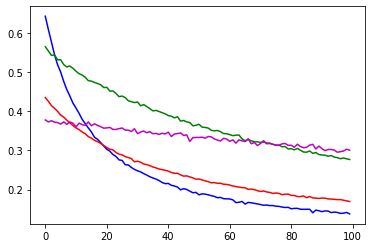

In [ ]:
#Your code here


my_LR_batches10 = LR_extended_minibatch(x.shape[1],x.shape[0], batch_size=10)
my_LR_batches10.train(torch.tensor(x),torch.tensor(y))
plt.plot(my_LR_batches10.loss_during_training,'-b',label='$batch size=$'+str(10))
print('Weights for '+str(10)+ ' batches:')
print(my_LR_batches10.output.weight)
print('Bias for '+str(10)+ ' batches:')
print(my_LR_batches10.output.bias)


my_LR_batches20 = LR_extended_minibatch(x.shape[1],x.shape[0], batch_size=20)
my_LR_batches20.train(torch.tensor(x),torch.tensor(y))
plt.plot(my_LR_batches20.loss_during_training,'-r',label='$batch size=$'+str(20))
print('Weights for '+str(20)+ ' batches:')
print(my_LR_batches20.output.weight)
print('Bias for '+str(20)+ ' batches:')
print(my_LR_batches20.output.bias)

my_LR_batches50 = LR_extended_minibatch(x.shape[1],x.shape[0], batch_size=50)
my_LR_batches50.train(torch.tensor(x),torch.tensor(y))
plt.plot(my_LR_batches50.loss_during_training,'-g',label='$batch size=$'+str(50))
print('Weights for '+str(50)+ ' batches:')
print(my_LR_batches50.output.weight)
print('Bias for '+str(50)+ ' batches:')
print(my_LR_batches50.output.bias)

my_LR_batches100 = LR_extended_minibatch(x.shape[1],x.shape[0], batch_size=100)
my_LR_batches100.train(torch.tensor(x),torch.tensor(y))
plt.plot(my_LR_batches100.loss_during_training,'-m',label='$batch size=$'+str(100))
print('Weights for '+str(100)+ ' batches:')
print(my_LR_batches100.output.weight)
print('Bias for '+str(100)+ ' batches:')
print(my_LR_batches100.output.bias)

plt.show()


#cuanto mas pequeño sea el mini-batch, mas gradientes calcula en una sola epoca
#por eso cuanto mas pequeño sea el minibatch, mas rapido baja
#y por eso el GD sera el que mas rapido disminuya el error

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Training loss after 0.000000e+00 epochs: 0.525811
Training loss after 1.000000e+01 epochs: 0.130060
Training loss after 2.000000e+01 epochs: 0.106746
Training loss after 3.000000e+01 epochs: 0.098573
Training loss after 4.000000e+01 epochs: 0.094326
Training loss after 5.000000e+01 epochs: 0.091671
Training loss after 6.000000e+01 epochs: 0.089832
Training loss after 7.000000e+01 epochs: 0.088472
Training loss after 8.000000e+01 epochs: 0.087425
Training loss after 9.000000e+01 epochs: 0.086595
[0.5258105414441514, 0.3374004763796743, 0.25820539027437234, 0.2155157365259602, 0.18911373219786093, 0.17118989355845, 0.1582862947252579, 0.14859133569456082, 0.1410324616393811, 0.13499356239982563, 0.13006021757916655, 0.12594688373551408, 0.12247770115457761, 0.11950801130114624, 0.11693957942192734, 0.11470031654022983, 0.11272624381653015, 0.11097323964706284, 0.1094118283325117, 0.10801107475935613, 0.10674552705758807, 0.1055936447196017, 0.1045431586604752, 0.1035808516833841, 0.10269

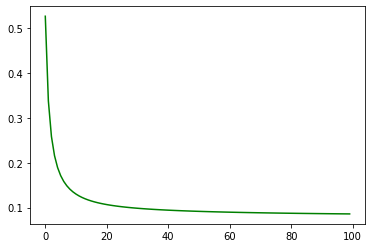

In [ ]:
my_LR_fullEpoch=LR_extended_minibatch(x.shape[1],x.shape[0],batch_size=1)
my_LR_fullEpoch.train(torch.tensor(x),torch.tensor(y))
print(my_LR_fullEpoch.loss_during_training)
plt.plot(my_LR_fullEpoch.loss_during_training,'-g',label='$Ev with size:$')
plt.show()


> **(Optional Exercise)**: Try to think how to modify the loss function to incorporate $L_2$ or $L_1$ regularization to the model. Implement a class for regularized logistic regression with a pre-defined regularization parameter.

In [ ]:


def loss_with_L2(myLR,lambda_reg='0.01'):
  l2 = 0
  for w in my_LR.parameters():
    if l2==0:
      l2= w.norm(2)
    else:
      l2=l2+w.norm(2)    
  loss= (1/N_train)*(y_pred - batch_ys).pow(2).sum() + lambda_reg* l2
  loss.backward()